# Clean With IR

## 1. Make the mesh

In [135]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [136]:
import gmsh
from dolfinx import fem
import pandas as pd
import numpy as np

from mesh_and_materials.mesh import *
from mesh_and_materials.materials import *
from space.space_and_forms import *
from dirichlet_bc.bc import *

In [137]:

# Sample geometry (all units in meters)

d_ins_oside = 6.3e-6
d_ins_pside = 3.2e-6
d_sample    = 1.84e-6
d_ir        = 0.062e-6

# Mesh bounds
x_length = d_ins_oside + d_ins_pside + d_sample + 2 * d_ir
mesh_xmin, mesh_xmax = -(x_length/2), x_length/2
mesh_ymin, mesh_ymax = -20e-6, 0

# Heating params
heating_FWHM = 13.2e-6


In [138]:

# Material regions (from left to right)
bx_ins_pside = mesh_xmin
BX_ins_pside = mesh_xmin + d_ins_pside

bx_ir_pside  = BX_ins_pside
BX_ir_pside  = bx_ir_pside + d_ir

bx_sample = BX_ir_pside
BX_sample = bx_sample + d_sample

bx_ir_oside = BX_sample
BX_ir_oside = bx_ir_oside + d_ir

bx_ins_oside = BX_ir_oside
BX_ins_oside = bx_ins_oside + d_ins_oside

ins_pside = Material(
    "pside ins",
    [bx_ins_pside, BX_ins_pside, mesh_ymin, mesh_ymax],
    properties={"rho_cv": 4131 * 668, "k": 10},
    mesh_size=0.1e-6
)

ir_pside = Material(
    "pside ir",
    boundaries=[bx_ir_pside, BX_ir_pside, mesh_ymin, mesh_ymax],
    properties={"rho_cv": 26504 * 130, "k": 352},
    mesh_size=0.02e-6
)

sample = Material(
    "sample",
    boundaries=[bx_sample, BX_sample, mesh_ymin, mesh_ymax],
    properties={"rho_cv": 5164 * 1158, "k": 3.9},
    mesh_size=0.08e-6
)

ir_oside = Material(
    "oside ir",
    boundaries=[bx_ir_oside, BX_ir_oside, mesh_ymin, mesh_ymax],
    properties={"rho_cv": 26504 * 130, "k": 352},
    mesh_size=0.02e-6
)

ins_oside = Material(
    "oside ins",
    boundaries=[bx_ins_oside, BX_ins_oside, mesh_ymin, mesh_ymax],
    properties={"rho_cv": 4131 * 668, "k": 10},
    mesh_size=0.1e-6
)

materials = [ins_pside, ir_pside, sample, ir_oside, ins_oside]

gmsh_domain = Mesh(
    name="clean",
    boundaries=[mesh_xmin, mesh_xmax, mesh_ymin, mesh_ymax],
    materials=materials
)


In [139]:
gmsh_domain.build_mesh()

no mesh errors found
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 10%] Meshing curve 2 (Line)
Info    : [ 20%] Meshing curve 3 (Line)
Info    : [ 20%] Meshing curve 4 (Line)
Info    : [ 30%] Meshing curve 5 (Line)
Info    : [ 40%] Meshing curve 6 (Line)
Info    : [ 40%] Meshing curve 7 (Line)
Info    : [ 50%] Meshing curve 9 (Line)
Info    : [ 60%] Meshing curve 10 (Line)
Info    : [ 60%] Meshing curve 11 (Line)
Info    : [ 70%] Meshing curve 13 (Line)
Info    : [ 70%] Meshing curve 14 (Line)
Info    : [ 80%] Meshing curve 15 (Line)
Info    : [ 90%] Meshing curve 17 (Line)
Info    : [ 90%] Meshing curve 18 (Line)
Info    : [100%] Meshing curve 19 (Line)
Info    : Done meshing 1D (Wall 0.00377234s, CPU 0.004607s)
Info    : Meshing 2D...
Info    : [  0%] Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : [ 30%] Meshing surface 2 (Plane, Frontal-Delaunay)
Info    : [ 50%] Meshing surface 3 (Plane, Frontal-Delaunay)
Info    : [ 70%] Meshing surface 4 (Plan

In [140]:
gmsh_domain.write('clean_with_ir.msh')
# Visualize in gmsh if desired
gmsh.open('clean_with_ir.msh')
gmsh.fltk.initialize()
gmsh.fltk.run()

Info    : Writing 'clean_with_ir.msh'...
Info    : Done writing 'clean_with_ir.msh'
Info    : Reading 'clean_with_ir.msh'...
Info    : 33 entities
Info    : 205776 nodes
Info    : 410885 elements                                                                                     
Info    : Done reading 'clean_with_ir.msh'                                                                       
-------------------------------------------------------
Version       : 4.13.1
License       : GNU General Public License
Build OS      : Linux64-sdk
Build date    : 20240524
Build host    : gmsh.info
Build options : 64Bit ALGLIB[contrib] ANN[contrib] Bamg Blas[petsc] Blossom Cgns DIntegration Dlopen DomHex Eigen[contrib] Fltk Gmm[contrib] Hxt Jpeg Kbipack Lapack[petsc] LinuxJoystick MathEx[contrib] Med Mesh Metis[contrib] Mmg Mpeg Netgen Nii2mesh ONELAB ONELABMetamodel OpenCASCADE OpenCASCADE-CAF OpenGL OpenMP OptHom PETSc Parser Plugins Png Post QuadMeshingTools QuadTri Solver TetGen/BR TinyXML2[

In [141]:
gmsh.finalize()

## 2. Run the simulation

In [142]:

# Experimental heating curve

df = pd.read_csv('experimental_data/geballe_2020_fig3_left_approx.csv')
df = df.copy().iloc[1:].reset_index(drop=True)

# split front/back columns and clean
df_pside = df[['Front', 'Unnamed: 1']].copy()
df_oside = df[['Back',  'Unnamed: 3']].copy()

df_pside.columns = ['time', 'temperature']
df_oside.columns = ['time', 'temperature']

df_pside = (df_pside
            .apply(pd.to_numeric)
            .dropna()
            .sort_values('time')
            .reset_index(drop=True))

df_oside = (df_oside
            .apply(pd.to_numeric)
            .dropna()
            .sort_values('time')
            .reset_index(drop=True))

df_pside['time'] = df_pside['time'] * 10**-6
df_oside['time'] = df_oside['time'] * 10**-6

df_pside['normed temperature'] = (
    df_pside['temperature'] - df_pside['temperature'].iloc[0]
) / (df_pside['temperature'].max() - df_pside['temperature'].min())

df_oside['normed temperature'] = (
    df_oside['temperature'] - df_oside['temperature'].iloc[0]
) / (df_pside['temperature'].max() - df_pside['temperature'].min())


In [143]:
import os
rebuild_mesh = False
mesh_file = 'clean_with_ir.msh'
if not os.path.exists(mesh_file) or rebuild_mesh:
    gmsh_domain.build_mesh()
    gmsh_domain.write(mesh_file)

dolfinx_domain = Mesh.msh_to_dolfinx(mesh_file) # (mesh, cell_tags, facet_tags)


Info    : Reading 'clean_with_ir.msh'...
Info    : 33 entities
Info    : 205776 nodes
Info    : 410885 elements                                                                                     
Info    : Done reading 'clean_with_ir.msh'                                                                       


In [144]:

spaces = Space(dolfinx_domain, V_family='Lagrange', V_degree=1, Q_family='DG', Q_degree=0)

rho_cv_fxn = spaces.assign_material_property(materials, 'rho_cv')
k_fxn = spaces.assign_material_property(materials, 'k')


In [145]:
spaces.cell_map = gmsh_domain.material_tags

In [146]:

ic_temp = 300.0
ic_fxn = spaces.initial_condition(ic_temp)
u_n = fem.Function(spaces.V)
u_n.x.array[:] = ic_fxn.x.array
u_n.x.scatter_forward()


In [147]:

from scipy.interpolate import make_interp_spline

pside_heating_spline_interp = make_interp_spline(df_pside['time'], df_pside['temperature'], k=3)
offset = df_pside['temperature'].iloc[0] - 300

def heating_offset(t):
    return float(pside_heating_spline_interp(t))

# Gaussian profile for inner boundary
heating_FWHM = 13.2e-6
coeff = -4.0 * np.log(2.0) / heating_FWHM**2
y_center = 0.0

def gaussian(x, y, t):
    amp = heating_offset(t)
    return (amp) * np.exp(coeff * (y - y_center)**2)

bcs = []
left_bc = RowDirichletBC(spaces.V, 'left', value=ic_temp)
right_bc = RowDirichletBC(spaces.V, 'right', value=ic_temp)
bottom_bc = RowDirichletBC(spaces.V, 'bottom', value=ic_temp)
top_bc = RowDirichletBC(spaces.V, 'top', value=ic_temp)
trans_pside_bc = RowDirichletBC(
    spaces.V,
    'x',
    coord=bx_ir_pside,
    length=heating_FWHM * 2,
    center=0.0,
    value=gaussian,
)


steady_pside_bc = RowDirichletBC(spaces.V, 'x', coord = bx_ir_pside, 
                                 length=heating_FWHM, 
                                 center = 0.0, 
                                 value = df_pside['temperature'].iloc[0])
steady_oside_bc = RowDirichletBC(spaces.V, 'x', 
                                 coord=BX_ir_oside, 
                                 length=heating_FWHM, 
                                 center=0.0, 
                                 value=df_oside['temperature'].iloc[0])

steady_obj_bcs = [steady_pside_bc, steady_oside_bc, left_bc, right_bc, bottom_bc]
steady_dolfinx_bcs = [x.bc for x in steady_obj_bcs]

In [148]:
RowDirichletBC.describe_row_bcs(steady_obj_bcs)

Row BC #0: x in [-2.532e-06, -2.532e-06]  y in [-6.600e-06, 2.642e-25]  (n = 331 DOFs)
Row BC #1: x in [-5.680e-07, -5.680e-07]  y in [-6.600e-06, 1.110e-24]  (n = 331 DOFs)
Row BC #2: x in [-5.732e-06, -5.732e-06]  y in [-2.000e-05, 1.583e-24]  (n = 201 DOFs)
Row BC #3: x in [5.732e-06, 5.732e-06]  y in [-2.000e-05, -9.525e-24]  (n = 201 DOFs)
Row BC #4: x in [-5.732e-06, 5.732e-06]  y in [-2.000e-05, -2.000e-05]  (n = 135 DOFs)


# Steady state solve

In [149]:
# Solve in steady state -------------------------------------------------------

from dolfinx.fem.petsc import assemble_matrix


spaces.build_steady_state_variational_forms(k_fxn)

A = assemble_matrix(spaces.a_form_steady, bcs=steady_dolfinx_bcs)
A.assemble()
b = fem.petsc.create_vector(spaces.L_form_steady)

solver = PETSc.KSP().create(A.getComm())
solver.setOperators(A)
solver.setType(PETSc.KSP.Type.PREONLY)
solver.getPC().setType(PETSc.PC.Type.LU)

from io_utilities.xdmf_utils import *

# set up output folder for steady-state
outputs_folder = os.path.join(os.getcwd(), 'sim_outputs')
save_folder = os.path.join(outputs_folder, 'steady_state_soln')
os.makedirs(save_folder, exist_ok=True)

# initialize XDMF for steady state
xdmf_ss = init_xdmf(spaces.mesh, save_folder, 'steady_state_solution')

u_ss = fem.Function(spaces.V)
u_ss.name = 'Steady State Temperature (K)'

with b.localForm() as local_b:
    local_b.set(0)

for x in steady_obj_bcs:
    x.update(0.0)

fem.petsc.assemble_vector(b, spaces.L_form_steady)
fem.petsc.apply_lifting(b, [spaces.a_form_steady], [steady_dolfinx_bcs])
b.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
fem.petsc.set_bc(b, steady_dolfinx_bcs)

solver = PETSc.KSP().create(A.getComm())
solver.setOperators(A)
solver.setType(PETSc.KSP.Type.PREONLY)
solver.getPC().setType(PETSc.PC.Type.LU)

solver.solve(b, u_ss.x.petsc_vec)

xdmf_ss.write_function(u_ss, 0.0)
xdmf_ss.close()


In [150]:
outer_obj_bcs = [left_bc, right_bc, bottom_bc]
outer_dolfinx_bcs = [x.bc for x in outer_obj_bcs]
# Assemble the free matrix for the transient problem
A_free = assemble_matrix(spaces.a_form_steady, bcs=outer_dolfinx_bcs)
A_free.assemble()

b_equiv = A_free.createVecRight()
A_free.mult(u_ss.x.petsc_vec, b_equiv)

In [151]:
b_equiv.array[heating_dofs]

array([ 1.04945672e+02,  1.04931533e+02,  1.04917588e+02,  1.05022440e+02,
        1.05037558e+02,  1.05005651e+02,  1.04959645e+02,  1.04988696e+02,
        1.04975854e+02,  1.04903680e+02,  1.04891304e+02,  1.05053931e+02,
        1.04876812e+02,  1.05375035e+02,  1.05124104e+02,  1.05106233e+02,
        1.05088438e+02,  1.05070596e+02,  1.04865036e+02,  1.05398425e+02,
        1.05304803e+02,  1.05329118e+02,  1.05348967e+02,  1.05142580e+02,
        1.05423233e+02,  1.05448231e+02,  1.05474174e+02,  1.05499892e+02,
        1.05526820e+02,  1.05554445e+02,  1.05240274e+02,  1.05262955e+02,
        1.05283428e+02,  1.05221225e+02,  1.05199372e+02,  1.05180885e+02,
        1.05161092e+02,  1.04852213e+02,  1.05582471e+02,  1.05611183e+02,
        1.04839887e+02,  1.05640962e+02,  1.04828147e+02,  1.05669667e+02,
        1.05832250e+02,  1.05865843e+02,  1.05796018e+02,  1.05701918e+02,
        1.05733213e+02,  1.05764784e+02,  1.05901954e+02,  1.05937165e+02,
        1.04816494e+02,  

In [152]:
u_chk = fem.Function(spaces.V)             # empty CG-1 temp
solver = PETSc.KSP().create(A_free.comm)
solver.setOperators(A_free)
solver.setType(PETSc.KSP.Type.PREONLY)
solver.getPC().setType(PETSc.PC.Type.LU)

solver.solve(b_equiv, u_chk.x.petsc_vec)
u_chk.x.scatter_forward()

err = np.linalg.norm(u_chk.x.array - u_ss.x.array, np.inf)
print(f"inf-norm difference  |u_chk - u_ss|  = {err:.3e}")

# b equiv reproduces load of steady state problem

inf-norm difference  |u_chk - u_ss|  = 1.042e-08


Tag ir boundaries

In [153]:
# Tag IR boundaries post mesh creation using facet coordinates
import numpy as np
from dolfinx import mesh as dmesh
from dolfinx.mesh import MeshTags

# Get mesh and geometry
mesh = spaces.mesh
geometry = mesh.geometry.x
facet_dim = mesh.topology.dim - 1
mesh.topology.create_connectivity(facet_dim, 0)

# IR region boundaries
ir_boundaries = [
    (bx_ir_pside, BX_ir_pside, 'pside ir'),
    (bx_ir_oside, BX_ir_oside, 'oside ir')
]

tol = 1e-12  # Tolerance for coordinate matching
facet_indices = np.arange(mesh.topology.index_map(facet_dim).size_local)
facet_midpoints = np.array([
    geometry[mesh.topology.connectivity(facet_dim, 0).links(f)].mean(axis=0)
    for f in facet_indices
])

# Tag facets for each IR left/right boundary
ir_facet_tags = []
ir_facet_values = []
tag_val = 1
ir_facet_map = {}
for x0, x1, tag in ir_boundaries:
    # Left boundary (x = x0)
    left_facets = facet_indices[np.abs(facet_midpoints[:, 0] - x0) < tol]
    ir_facet_tags.append(left_facets)
    ir_facet_values.extend([tag_val] * len(left_facets))
    ir_facet_map[f"{tag}_left"] = tag_val
    tag_val += 1
    # Right boundary (x = x1)
    right_facets = facet_indices[np.abs(facet_midpoints[:, 0] - x1) < tol]
    ir_facet_tags.append(right_facets)
    ir_facet_values.extend([tag_val] * len(right_facets))
    ir_facet_map[f"{tag}_right"] = tag_val
    tag_val += 1

from dolfinx.mesh import meshtags
# Flatten and create MeshTags
all_facets = np.concatenate(ir_facet_tags)
all_values = np.array(ir_facet_values, dtype=np.int32)
if len(all_facets) > 0:
    ir_mesh_tags = meshtags(mesh, facet_dim, all_facets, all_values)
else:
    ir_mesh_tags = None

# Save for later use
spaces.ir_facet_tags = ir_mesh_tags
spaces.ir_facet_map = ir_facet_map

print("Tagged IR boundaries:", ir_facet_map)

Tagged IR boundaries: {'pside ir_left': 1, 'pside ir_right': 2, 'oside ir_left': 3, 'oside ir_right': 4}


In [154]:
spaces.cell_map

{'pside ins': 1, 'pside ir': 2, 'sample': 3, 'oside ir': 4, 'oside ins': 5}

In [155]:
transient_obj_bcs = [left_bc, right_bc, bottom_bc, trans_pside_bc]
transient_dolfinx_bcs = [x.bc for x in transient_obj_bcs]

In [159]:
time_stop = 7.0e-6
num_steps = 200
dt = time_stop/num_steps

u_n = u_ss.copy()  # Start from steady state solution
a_form, L_form = spaces.build_variational_forms(rho_cv_fxn, k_fxn, u_n, dt)
u_n.name = 'Temperature (K)'

# Strip out the p-side rows so only the o-side load remains
b_oside = b_equiv.copy()

heating_dofs = trans_pside_bc.row_dofs
b_oside.setValues(trans_pside_bc.row_dofs, np.zeros(len(heating_dofs)))
b_oside.scale(dt)  # Scale the load by dt
b_oside.assemblyBegin()
b_oside.assemblyEnd()


# Matrix that *does* clamp the p-side
A = assemble_matrix(a_form, bcs=transient_dolfinx_bcs)
A.assemble()
# setup solver

solver = PETSc.KSP().create(A.getComm())
solver.setOperators(A)
solver.setType(PETSc.KSP.Type.PREONLY)
solver.getPC().setType(PETSc.PC.Type.LU)

from io_utilities.xdmf_utils import *

outputs_folder = os.path.join(os.getcwd(), 'sim_outputs')
save_folder = os.path.join(outputs_folder, 'new_trans_test')
os.makedirs(save_folder, exist_ok=True)

xdmf = init_xdmf(spaces.mesh, save_folder, 'solution')
xdmf.write_function(u_n, 0.0)


In [160]:
for x in transient_obj_bcs:
    x.update(0.0)

b = b_oside.copy()  # Copy the oside load

progress_interval = max(1, num_steps // 10)
for step in range(num_steps):
    t = (step+1)*dt
    for bc in transient_obj_bcs:
        bc.update(t)

    b = b_oside.copy()  # Copy the oside load
    fem.petsc.assemble_vector(b, L_form)
    fem.petsc.apply_lifting(b, [a_form], [transient_dolfinx_bcs])
    b.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
    fem.petsc.set_bc(b, transient_dolfinx_bcs)

    solver.solve(b, u_n.x.petsc_vec)
    u_n.x.scatter_forward()

    u_n.x.array[:] = u_n.x.array

    xdmf.write_function(u_n, t)

    if (step + 1) % progress_interval == 0 or (step + 1) == num_steps:
        percent = int((step + 1) / num_steps * 100)
        print(f"Simulation progress: {percent}% (step {step + 1}/{num_steps})")

xdmf.close()


Simulation progress: 10% (step 20/200)
Simulation progress: 20% (step 40/200)
Simulation progress: 30% (step 60/200)
Simulation progress: 40% (step 80/200)
Simulation progress: 50% (step 100/200)
Simulation progress: 60% (step 120/200)
Simulation progress: 70% (step 140/200)
Simulation progress: 80% (step 160/200)
Simulation progress: 90% (step 180/200)
Simulation progress: 100% (step 200/200)


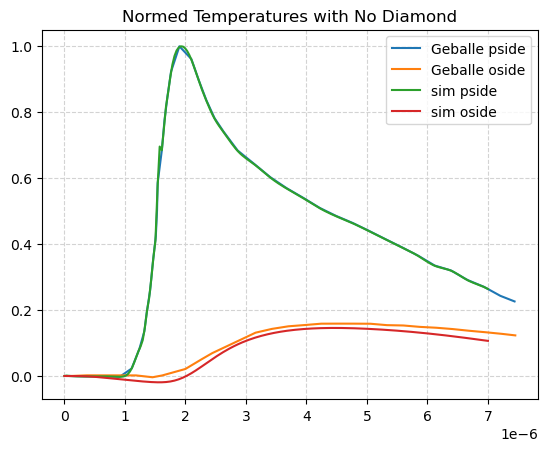

In [161]:
from io_utilities.xdmf_extract import *

time, data = extract_point_timeseries_xdmf(
    os.path.join(save_folder, 'solution.xdmf'),
    function_name='Temperature (K)',
    query_points=[(bx_ir_pside, 0), (BX_ir_oside, 0)]
)

sim_df = pd.DataFrame({'time': time,
                       'pside': data[0],
                       'oside': data[1]})

sim_df['normed pside'] = (sim_df['pside'] - sim_df['pside'].iloc[0]) / (sim_df['pside'].max() - sim_df['pside'].min())
sim_df['normed oside'] = (sim_df['oside'] - sim_df['oside'].iloc[0]) / (sim_df['pside'].max() - sim_df['pside'].min())

import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.set_title('Normed Temperatures with No Diamond')
ax.plot(df_pside['time'], df_pside['normed temperature'], label='Geballe pside')
ax.plot(df_oside['time'], df_oside['normed temperature'], label='Geballe oside')
ax.plot(sim_df['time'], sim_df['normed pside'], label='sim pside')
ax.plot(sim_df['time'], sim_df['normed oside'], label='sim oside')
ax.grid(True, ls = '--', color = 'lightgray')


ax.legend()
plt.show()


In [ ]:
max(sim_df['pside'])

2291.7715498251996

In [ ]:
max(sim_df['normed oside'] - max(df_oside['normed temperature']))

nan

In [ ]:
df_oside['temperature'].iloc[0] - df_pside['temperature'].iloc[0]

np.float64(287.88913300000013)

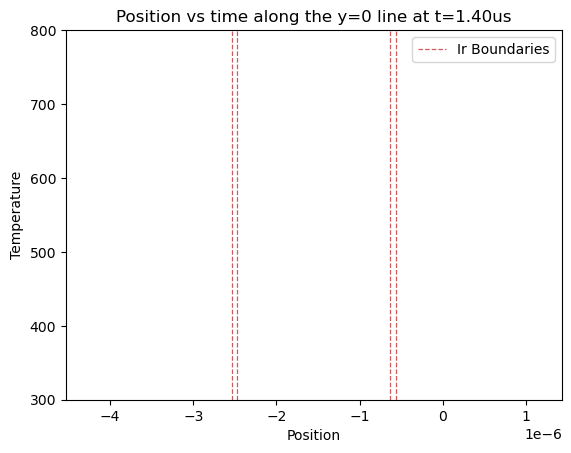

In [ ]:

query_points = []
xmin = bx_ir_pside - 2e-6
xmax = BX_ir_oside + 2e-6
samples = 200

for x in np.linspace(xmin, xmax, samples):
    query_points.append((x, 0.0))

time, data = extract_point_timeseries_xdmf(
    os.path.join(save_folder, 'solution.xdmf'),
    function_name='Temperature (K)',
    query_points=query_points
)
locations = np.arange(data.shape[0])

sim_df = pd.DataFrame(data, index=locations.astype(int), columns=time)

fig, ax = plt.subplots()

t0 = 40
location_series = (locations/samples) * (xmax - xmin) + xmin
ymin = 300
ymax = 800

ax.plot(location_series, sim_df.iloc[:, t0], zorder = 3, color = 'black')
ax.vlines([BX_sample, bx_sample, bx_ir_pside, BX_ir_oside], ymin=ymin, ymax=ymax, ls='--', label='Ir Boundaries', color='indianred', zorder=2, lw=0.9)
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_xlabel('Position')
ax.set_ylabel('Temperature')
ax.set_title(f'Position vs time along the y=0 line at t={t0*dt*1e6:.2f}us')
ax.legend()
plt.show()
